   # AUDIO EMOTION DETECTION MODEL CREATION

Import the required libraries

In [21]:
import os
import numpy as np
import pandas as pd
import glob
import random
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam


Load in the dataset

In [56]:
RAVDESS = "C:/Users/Taarini/Desktop/Audio_emotion_detection/audio_speech_actors_01-24"
audio_list= os.listdir(RAVDESS)
print(audio_list)  

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


Stratify dataset to get female audio emotions only

In [23]:
emotion = []
gender = []
path = []
# Iterate through each actor's folder 
for a in audio_list:
    files = os.listdir(os.path.join(RAVDESS, a))
    for file in files:
        parts = file.split('.')[0].split('-')
        emotion_code = int(parts[2])
        
        emotion.append(emotion_code)  # Append emotion found
        
        actor_id = int(parts[6])

       
        # Determine gender based on actor ID
        if actor_id % 2 == 0:
            gen = "female"
        else:
            gen = "male"
        gender.append(gen)

        # Append file path
        path.append(os.path.join(RAVDESS, a, file))


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)




RAV_df_female = RAV_df[RAV_df['gender'] == 'female'] #Filters out data to store only female voices.


RAV_df_female = RAV_df_female[['emotion', 'path', 'labels']]


RAV_df_female.reset_index(drop=True, inplace=True) # Reset the index of the dataframe

print(RAV_df_female['labels'].value_counts())


labels
female_calm        96
female_happy       96
female_sad         96
female_angry       96
female_fear        96
female_disgust     96
female_surprise    96
female_neutral     48
Name: count, dtype: int64


In [24]:
def extract_mel_spectrogram(file_path, n_mels=128, fmax=8000):  #extracts mel spectogram features from the audio files.
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB


In [25]:
def save_spectrogram_as_image(S_dB, file_path):  #saves the spectograms as images.
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=22050, hop_length=512, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [26]:
image_dir = 'spectrogram_images_female'  #creates a directory for all female designated images
os.makedirs(image_dir, exist_ok=True)
image_paths = []

for index, row in RAV_df_female.iterrows():
    mel_spectrogram = extract_mel_spectrogram(row['path'])
    image_path = os.path.join(image_dir, f"{index}.png")
    save_spectrogram_as_image(mel_spectrogram, image_path)
    image_paths.append(image_path)

RAV_df_female['image_path'] = image_paths

In [57]:
label_encoder = LabelEncoder()  # Encodes labels
RAV_df_female['labels_encoded'] = label_encoder.fit_transform(RAV_df_female['labels'])


RAV_df_female['labels_encoded'] = RAV_df_female['labels_encoded'].astype(str) # Converts labels to string


# Split the dataset
train_df, test_df = train_test_split(RAV_df_female, test_size=0.2, random_state=42, stratify=RAV_df_female['labels_encoded'])

print(train_df.head())

      emotion                                               path  \
90      angry  C:/Users/Taarini/Desktop/Audio_emotion_detecti...   
114  surprise  C:/Users/Taarini/Desktop/Audio_emotion_detecti...   
320       sad  C:/Users/Taarini/Desktop/Audio_emotion_detecti...   
340      fear  C:/Users/Taarini/Desktop/Audio_emotion_detecti...   
379     happy  C:/Users/Taarini/Desktop/Audio_emotion_detecti...   

              labels                         image_path labels_encoded  
90      female_angry   spectrogram_images_female\90.png              0  
114  female_surprise  spectrogram_images_female\114.png              7  
320       female_sad  spectrogram_images_female\320.png              6  
340      female_fear  spectrogram_images_female\340.png              3  
379     female_happy  spectrogram_images_female\379.png              4  


Prepare data for training

In [58]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='labels_encoded',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='labels_encoded',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 576 validated image filenames belonging to 8 classes.
Found 144 validated image filenames belonging to 8 classes.


In [43]:
num_classes = len(label_encoder.classes_)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [46]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 647ms/step - accuracy: 0.1130 - loss: 2.1190 - val_accuracy: 0.1875 - val_loss: 25.7327
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.2448 - loss: 2.0179 - val_accuracy: 0.3889 - val_loss: 90.7993
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.3188 - loss: 1.7845 - val_accuracy: 0.4514 - val_loss: 91.0002
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.4249 - loss: 1.5553 - val_accuracy: 0.3611 - val_loss: 167.5189
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.4511 - loss: 1.4036 - val_accuracy: 0.3889 - val_loss: 156.8812
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.5126 - loss: 1.3766 - val_accuracy: 0.5139 - val_loss: 151.5025
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.5640 - loss: 1.2138 - val_accuracy: 0.5347 - val_loss: 156.0484
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.6077 - loss: 1.1073 - val_

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.9703 - loss: 0.0740 - val_accuracy: 0.7708 - val_loss: 302.0448


In [50]:
model.evaluate(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.7708 - loss: 333.3934


[302.0447998046875, 0.7708333134651184]

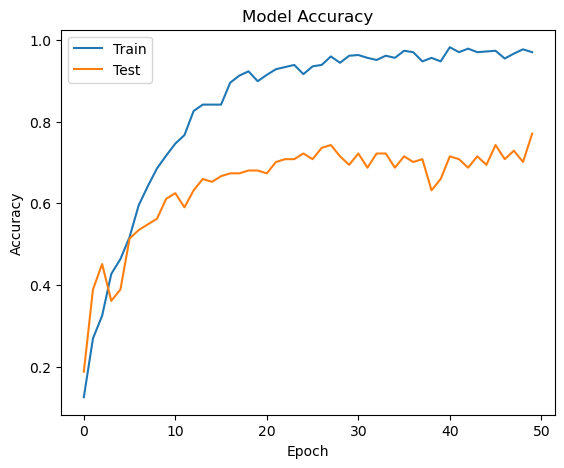

In [51]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


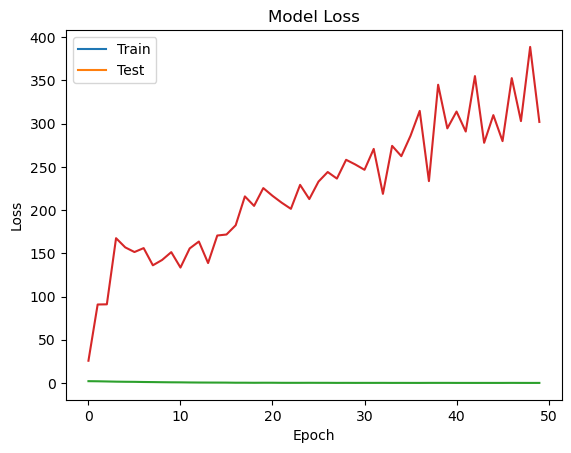

In [52]:
plt.plot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


Save the model

In [53]:
model_json=model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)

In [54]:
model.save('audio_emotion_detection.keras')

In [55]:
np.save('classes.npy', label_encoder.classes_)